## Example 1 - Common Driver

Here we investigate the statistical association between summer precipitation (JJA mean) in Denmark (DK) and the Mediterranean (MED). A standard correlation test shows them to be negatively correlated (r = -0.24). However, this association is not causal but is due to both regions being affected by the position of the North Atlantic storm tracks, as described by the North Atlantic Oscillation (NAO) index.

<img src="../images/ex1.png" width="500" height="600">

### References / Notes

1. Mediterranean region as described in http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.368.3679&rep=rep1&type=pdf


## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import iris
import iris.quickplot as qplt

import statsmodels.api as sm
from scipy import signal
from scipy import stats

### Step 1) Load the data + Extract regions of interest

In [2]:
precip = iris.load_cube('../sample_data/precip_jja.nc', 'Monthly Mean of Precipitation Rate')
nao = iris.load_cube('../sample_data/nao_jja.nc', 'nao')

#### Extract regions of interest:

#### Mediterranean (MED)

In [3]:
med = precip.intersection(longitude=(10.0, 30.0), latitude=(36, 41.0))

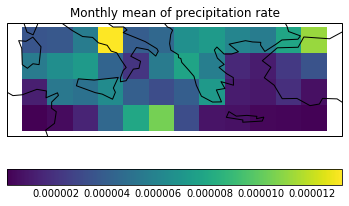

In [4]:
qplt.pcolormesh(med[0])
plt.gca().coastlines()

#### Denmark (DK)

In [5]:
dk = precip.intersection(longitude=(2, 15), latitude=(50, 60))

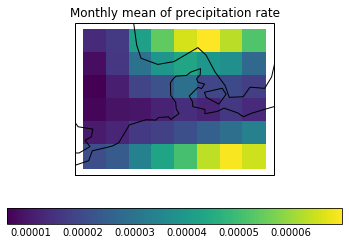

In [6]:
qplt.pcolormesh(dk[0])
plt.gca().coastlines()

#### Create regional means

In [7]:
def areal_mean(cube):
    grid_areas = iris.analysis.cartography.area_weights(cube)
    cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    return cube

In [8]:
# Areal mean
med = areal_mean(med)
dk = areal_mean(dk)

/envs/auto-build-envs/datasci/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/envs/auto-build-envs/datasci/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


### Step 2)  Plotting + Data Processing

/envs/auto-build-envs/datasci/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


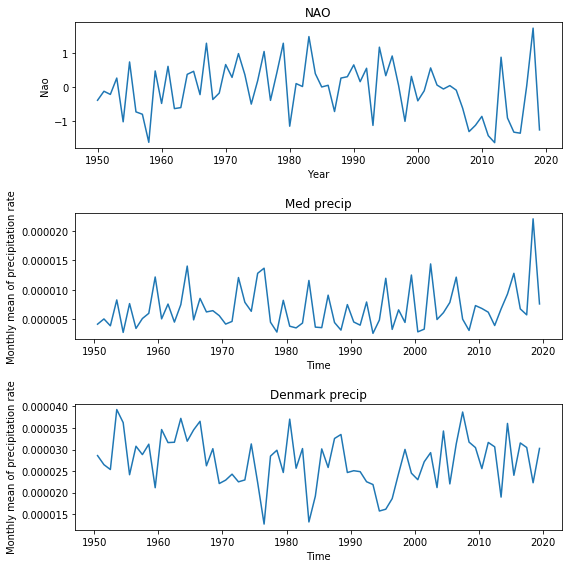

In [9]:
fig = plt.figure(figsize=(8, 8))

plt.subplot(311)
qplt.plot(nao)
plt.title('NAO')

plt.subplot(312)
qplt.plot(med)
plt.title('Med precip')

plt.subplot(313)
qplt.plot(dk)
plt.title('Denmark precip')
plt.tight_layout()

#### Standardize the data (zero mean, unit variance)

In [11]:
NAO = (nao - np.mean(nao.data))/np.std(nao.data)
MED = (med - np.mean(med.data))/np.std(med.data)
DK = (dk - np.mean(dk.data))/np.std(dk.data)

#### Detrend

In [12]:
NAO = signal.detrend(NAO.data)
MED = signal.detrend(MED.data)
DK = signal.detrend(DK.data)

### Step 3) Data analysis

In [13]:
#==========================================================
# Calculate the Pearson Correlation of MED and DK
#==========================================================

X = DK[:]
Y = MED[:]

r_dk_med, p_dk_med = stats.pearsonr(X, Y)

print(" The correlation of DK and MED is ", round(r_dk_med,2))
print(" p-value is ", round(p_dk_med, 2))

 The correlation of DK and MED is  -0.24
 p-value is  0.04


In [15]:
#==================================================================================
# Condtion out the effect of NAO 

# here this is done by calculating the partial correlation of DK and MED conditiona on NAO
# alternatively, one could also just regress DK on on MED and NAO
#==================================================================================

# 1) regress MED on NAO
X = NAO[:]
Y = MED[:]

model = sm.OLS(Y,X)
results = model.fit()
res_med = results.resid

# 2) regress DK on NAO
X = NAO[:]
Y = DK[:]

model = sm.OLS(Y,X)
results = model.fit()
res_dk = results.resid

# 3) correlate the residuals (= partial correlation)
par_corr, p = stats.pearsonr(res_dk, res_med)

print(" The partial correlation of DK and MED (cond on NAO) is ", round(par_corr, 2))

 The partial correlation of DK and MED (cond on NAO) is  0.01


In [16]:
#=====================================================
# Determine the causal effect from NAO --> MED
#=====================================================

Y = MED[:]
X = NAO[:]

model = sm.OLS(Y,X)
results = model.fit()
ce_nao_med = results.params[0]

print("The causal effect of NAO on MED  is ", round(ce_nao_med,2))

The causal effect of NAO on MED  is  0.42


In [17]:
#=====================================================
# Determine the causal effect from NAO --> DK
#=====================================================

Y = DK[:]
X =  NAO[:]

model = sm.OLS(Y,X)
results = model.fit()

ce_nao_dk = results.params[0]

print("The effect of NAO on DK  is ", round(ce_nao_dk,2))

The effect of NAO on DK  is  -0.58


In [19]:
#=====================================================
# Path tracing rule:
#=====================================================

exp_corr_dk_med = ce_nao_med * ce_nao_dk

print("The expected correlation of MED and DK  is ", round(exp_corr_dk_med,2))
print("The actual correlation of MED and DK  is ", round(r_dk_med, 2))

The expected correlation of MED and DK  is  -0.25
The actual correlation of MED and DK  is  -0.24


### Conclusions

There is a spurious correlation of MED and DK due to the influence of the common driver NAO. If one controls for NAO the correlation is shown to be negligible.
